In [201]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from scipy.signal import periodogram
from sklearn.ensemble import RandomForestRegressor

In [202]:
data_folder = Path('data')

In [203]:

holidays_events = pd.read_csv(
    data_folder / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
)
holidays_events = holidays_events.set_index('date').to_period('D')
holidays_events.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


Get sales from 2017.

In [204]:
store_sales = pd.read_csv(
    data_folder / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales[store_sales['date'] >= '2017']
store_sales = store_sales.set_index(['date', 'store_nbr', 'family']).sort_index()

store_sales.head()

sales  onpromotion
date       store_nbr family                        
2017-01-01 1         AUTOMOTIVE    0.0            0
                     BABY CARE     0.0            0
                     BEAUTY        0.0            0
                     BEVERAGES     0.0            0
                     BOOKS         0.0            0

Sales that average over store number, only accounting for date and product family:

In [205]:
def get_family_sales(sales):
    return (
        sales
        .groupby(['family', 'date'], observed=False)
        .mean()
        [['sales', 'onpromotion']]
        .unstack('family')
    )

family_sales = get_family_sales(store_sales)
family_sales.head()

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222221  0.000000   
2017-01-02  11.481482  0.259259  11.648149  6208.055664  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814941  0.814815   
2017-01-04   6.833333  0.333333   6.888889  3911.833252  0.759259   
2017-01-05   6.333333  0.351852   5.925926  3258.796387  0.407407   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518518    3.629167   
2017-01-02   844.836304   14.203704  2233.648193  1545.000000  539.114807   
2017-01-03   665.124146   10.629630  1711.907349  1204.203735  404.300049   
2017-01-04   594.160645   11.185185  1508.036987  1107.796265  309.397675   
2017-01-05   495.511597   12.444445  1241.833374   829.277771  260.776489   

            ... onpromotion                                       \
family      ...   MAGAZINES     MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                    
2017-01-01  ...         0.0  0.018519      0.111111     0.018519   
2017-01-02  ...         0.0  0.462963     10.592593     0.537037   
2017-01-03  ...         0.0  0.481481      9.722222     0.444444   
2017-01-04  ...         0.0  0.370370     12.037037     0.444444   
2017-01-05  ...         0.0  8.981481      5.666667     0.000000   

                                                                         \
family     PLAYERS AND ELECTRONICS   POULTRY PREPARED FOODS     PRODUCE   
date                                                                      
2017-01-01                     0.0  0.000000       0.037037    0.129630   
2017-01-02                     0.0  0.259259       1.166667    5.629630   
2017-01-03                     0.0  0.388889       1.351852   56.296296   
2017-01-04                     0.0  0.296296       5.444444  101.277778   
2017-01-05                     0.0  0.296296       0.907407    5.018519   

                                                 
family     SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
date                                             
2017-01-01                        0.0  0.000000  
2017-01-02                        0.0  0.407407  
2017-01-03                        0.0  0.407407  
2017-01-04                        0.0  0.333333  
2017-01-05                        0.0  0.444444  

[5 rows x 66 columns]

In [206]:
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    ['sales']
)
average_sales.head()

date
2017-01-01      6.780303
2017-01-02    786.928406
2017-01-03    619.740234
2017-01-04    555.607971
2017-01-05    436.375397
Freq: D, Name: sales, dtype: float32

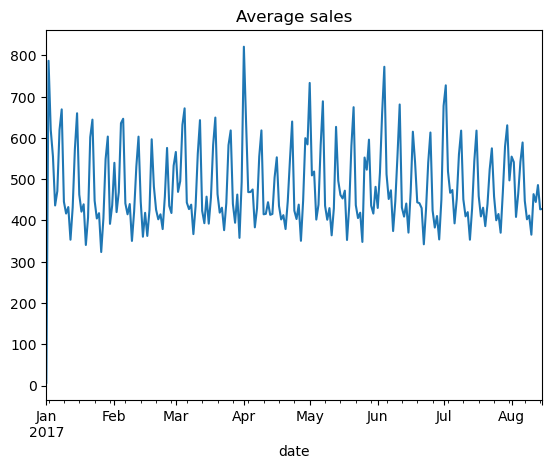

In [207]:
average_sales.plot(title='Average sales');

Draw seasonality plot.

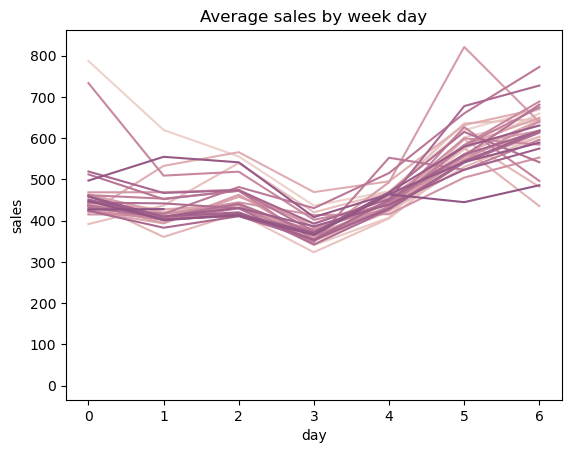

In [208]:
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
ax = sns.lineplot(x="day", y="sales", hue="week", data=X, legend=False)
ax.set_title("Average sales by week day");

Draw periodogram to see the strenght of different frequencies and to spot seasonal components.

In [209]:
def plot_periodogram(y, fs, detrend="linear", ax=None):
    if ax is None:
        _, ax = plt.subplots()
    frequencies, spectrum = periodogram(y, fs=fs, detrend=detrend, scaling="spectrum")
    ax.step(frequencies, spectrum)
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

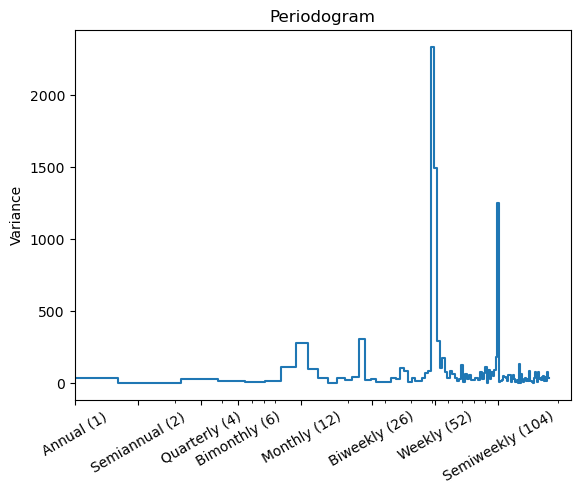

In [210]:
plot_periodogram(average_sales, fs=365);

The seasonality plot and the periodogram suggest strong weekly seasonality. The periodogram also suggests some monthly seasonality. Add these seasonal components to the model.

In [211]:
y = store_sales.unstack(['store_nbr', 'family'])[['sales']]
y.columns = y.columns.rename("store", level=0)

fourier = CalendarFourier(freq="ME", order=4)

dp = DeterministicProcess(
        index=y.index,
        constant=True,
        order=1,
        seasonal=True,
        additional_terms=[fourier],
        drop=True,
    )

X = dp.in_sample()
X

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=ME)","cos(1,freq=ME)","sin(2,freq=ME)","cos(2,freq=ME)","sin(3,freq=ME)","cos(3,freq=ME)","sin(4,freq=ME)","cos(4,freq=ME)"
date,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,223.0,0.0,0.0,0.0,0.0,1.0,0.0,0.897805,-0.440394,-0.790776,-0.612106,-0.201299,0.979530,0.968077,-0.250653
2017-08-12,1.0,224.0,0.0,0.0,0.0,0.0,0.0,1.0,0.790776,-0.612106,-0.968077,-0.250653,0.394356,0.918958,0.485302,-0.874347
2017-08-13,1.0,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651372,-0.758758,-0.988468,0.151428,0.848644,0.528964,-0.299363,-0.954139


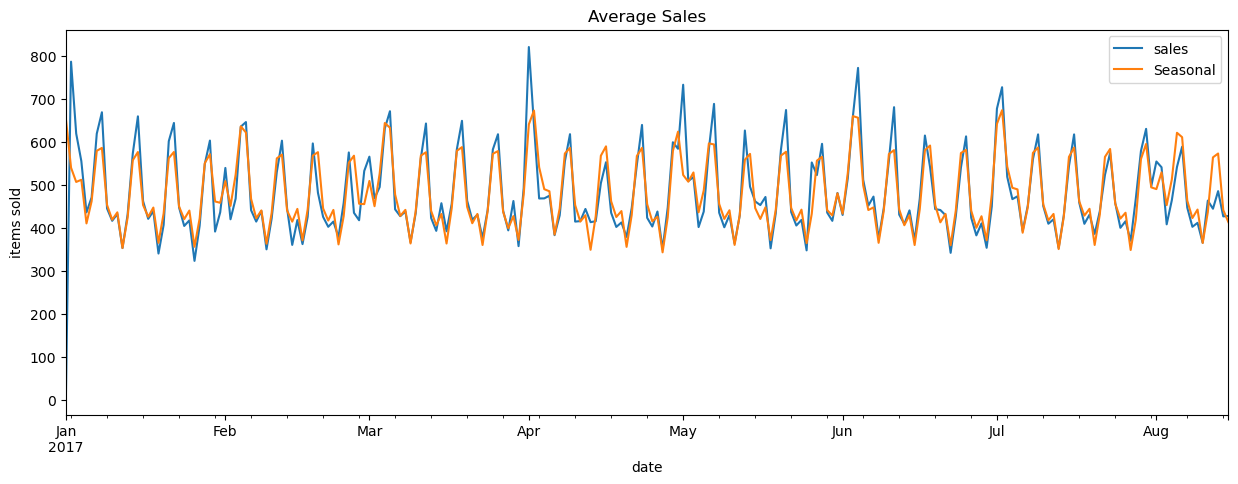

In [212]:
model = LinearRegression().fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)
y_pred_avg = y_pred.mean(axis=1)
ax = average_sales.plot(title="Average Sales", ylabel="items sold")
ax = y_pred_avg.plot(ax=ax, label="Seasonal", figsize=(15, 5))
ax.legend()
plt.show()

In [213]:
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
    .groupby('date').first()
)
holidays = holidays[~((holidays.index.month == 12) & (holidays.index.day == 25))]
holidays.head()

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi


Holidays seem to have some predicting power for sales:

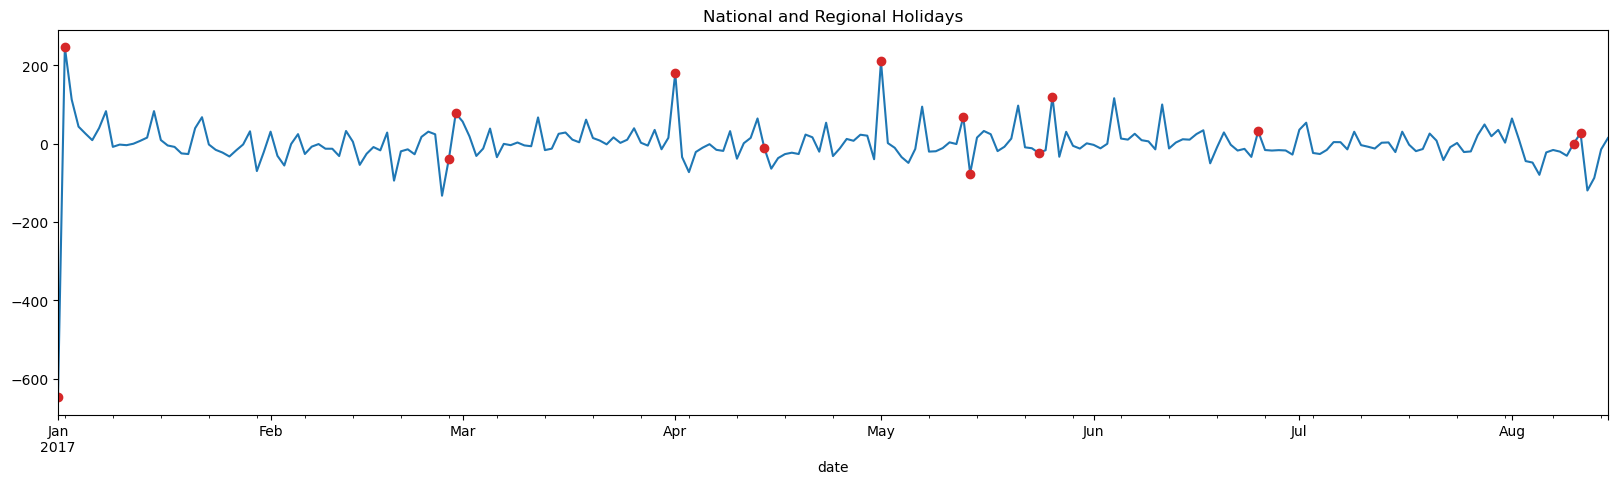

In [214]:
ax = y_deseason.plot(figsize=(20, 5))
plt.plot(holidays.index, y_deseason[holidays.index], 'o', color='C3')
ax.set_title('National and Regional Holidays');

Add indicator features for holidays:

In [215]:
def add_holiday_features(X):
    X.index.name = 'date'
    X_holidays = pd.get_dummies(holidays['description'], dtype=float)
    X2 = X.join(X_holidays, on='date').fillna(0.0)
    return X2

X = add_holiday_features(X)
X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=ME)","cos(1,freq=ME)",...,Dia de la Madre-1,Dia del Trabajo,Primer Grito de Independencia,Primer dia del ano,Provincializacion de Cotopaxi,Provincializacion de Imbabura,Traslado Batalla de Pichincha,Traslado Primer Grito de Independencia,Traslado Primer dia del ano,Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Some holiday sales are now predicted more accurately, such as April 1st:

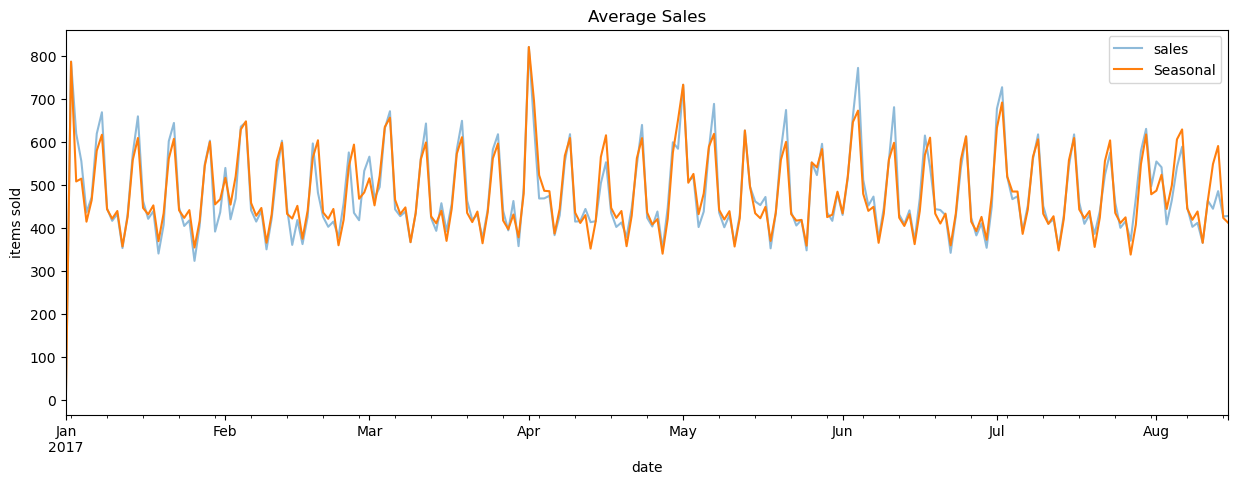

In [216]:
model = LinearRegression().fit(X, y)
y_pred = pd.DataFrame(
    model.predict(X),
    index=X.index,
    columns=y.columns
)
y_pred_avg = y_pred.mean(axis=1)

ax = average_sales.plot(alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred_avg.plot(ax=ax, label="Seasonal", figsize=(15, 5))
ax.legend();

Let's try to improve the fit by using a hybrid model that uses two models. The first model is fit to the original data and the second model to the residuals of the first model. In this implementation, a separate model is fit for the mean residuals of each product family.

In [217]:
class BoostedHybrid:
    def __init__(self, model_1, model_2_cls):
        self.model_1 = model_1
        self.model_2_cls = model_2_cls
        self.y_columns = None
        self.models2 = []

    def fit(self, X_1, X_2, y):
        self.model_1.fit(X_1, y)

        y_fit = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, columns=y.columns,
        )
        y_resid = y - y_fit
        # Average over store number
        y_resid = y_resid.stack(level=['store_nbr', 'family'], future_stack=True).groupby(['date', 'family'], observed=False).mean()

        # Fit separate model for each product family
        for i, (family, group) in enumerate(y_resid.groupby(level='family', observed=False)):
            m2 = self.model_2_cls()
            x2 = X_2[X_2['family'] == i]
            m2.fit(x2, group['sales'])
            self.models2.append(m2)

        self.y_columns = y.columns # Save column names for predict method
        self.y_resid = y_resid

    def predict(self, X_1, X_2):
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, columns=self.y_columns,
        )
        y_pred = y_pred.stack(["store_nbr", "family"], future_stack=True)

        y_pred_resid = (
            pd.DataFrame(index=X_1.index, columns=y.columns)
            .infer_objects(copy=False)
            .stack(level=['store_nbr', 'family'], future_stack=True)
            .groupby(['date', 'family'], observed=False)
            .sum()
        )

        # Predict residuals for each product family using the stored models
        for i, (family, group) in enumerate(y_pred_resid.groupby(level='family', observed=False)):
            x2 = X_2[X_2['family'] == i]
            y_pred_r = self.models2[i].predict(x2)
            y_pred_resid.loc[group.index, 'sales'] = y_pred_r

        self.y_pred_resid = y_pred_resid

        # Add store_nbr back to the residual dataframe and use same prediction for each store_nbr give date and product family
        stores = y.columns.get_level_values('store_nbr').categories
        n_dates = len(y_pred_resid.index.get_level_values('date'))
        y_pred_resid_wide = pd.concat([y_pred_resid] * len(stores))
        y_pred_resid_wide['store_nbr'] = stores.repeat(n_dates)
        y_pred_resid_wide = y_pred_resid_wide.set_index('store_nbr', append=True).reorder_levels(['date', 'store_nbr', 'family']).loc[y_pred.index]
        self.y_pred_resid_wide = y_pred_resid_wide

        y_pred += y_pred_resid_wide

        return y_pred.unstack(["store_nbr", "family"]).clip(0.0)

Use family and mean number of promoted products as features for the second (residual) model:

In [218]:
def get_family_features(family_sales):
    X_2 = family_sales.stack(future_stack=True)
    X_2 = X_2.reset_index('family')

    le = LabelEncoder()
    X_2['family'] = le.fit_transform(X_2['family'])

    X_2["day"] = X_2.index.day
    X_2 = X_2.drop('sales', axis=1)
    return X_2

X_2 = get_family_features(family_sales)
X_2.head()

,family,onpromotion,day
date,,,
2017-01-01,0,0.000000,1
2017-01-01,1,0.000000,1
2017-01-01,2,0.000000,1
2017-01-01,3,0.703704,1
2017-01-01,4,0.000000,1


In [219]:
model = BoostedHybrid(LinearRegression(), RandomForestRegressor)
model.fit(X, X_2, y)
y_pred = model.predict(X, X_2)
y_pred.head()

store           sales                                                          \
store_nbr           1                                                           
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-01-01   0.207457  0.000000  0.000000     0.000000  0.040052     3.700026   
2017-01-02   5.115460  0.043936  0.000000  1550.133063  0.000000   180.896754   
2017-01-03   4.418764  0.000000  4.585604  3214.193520  1.035826   505.698009   
2017-01-04   3.853309  0.018789  4.585178  3012.701891  1.057626   511.533042   
2017-01-05   3.129752  0.039961  3.567735  2465.769416  0.800045   434.190391   

store                                                         ...            \
store_nbr                                                     ...         9   
family     CELEBRATION     CLEANING        DAIRY        DELI  ... MAGAZINES   
date                                                          ...             
2017-01-01    0.314015     0.000000     0.000000    4.425282  ...  0.547724   
2017-01-02    0.000000   331.636759   406.282344   48.884300  ...  4.964996   
2017-01-03   15.134895  1044.685831  1006.057996  214.191324  ...  1.933827   
2017-01-04   14.964477  1107.497160  1022.519779  171.003304  ...  2.010063   
2017-01-05   17.698723   855.045390   778.344528  130.076153  ...  1.576738   

store                                                                      \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-01-01    1.263958      2.161432     0.086482                0.442907   
2017-01-02  678.149783   1238.897336    11.540122               40.637176   
2017-01-03  513.201870    757.116989     8.427304               16.515300   
2017-01-04  447.757384    638.696889     8.958876               14.824065   
2017-01-05  601.925577    575.641089     5.853463               13.623415   

store                                                                          \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-01-01   13.700741       0.000000     1.918810                        0.0   
2017-01-02  846.817521     116.103695  3187.606011                        0.0   
2017-01-03  576.553827     134.869350  3142.374204                        0.0   
2017-01-04  499.525901     116.172235  1780.123557                        0.0   
2017-01-05  429.225898     109.312993  1584.107418                        0.0   

store                  
store_nbr              
family        SEAFOOD  
date                   
2017-01-01   0.683624  
2017-01-02  23.091630  
2017-01-03  19.555107  
2017-01-04  15.979757  
2017-01-05  15.369844  

[5 rows x 1782 columns]

Check how the second model fits the residuals:

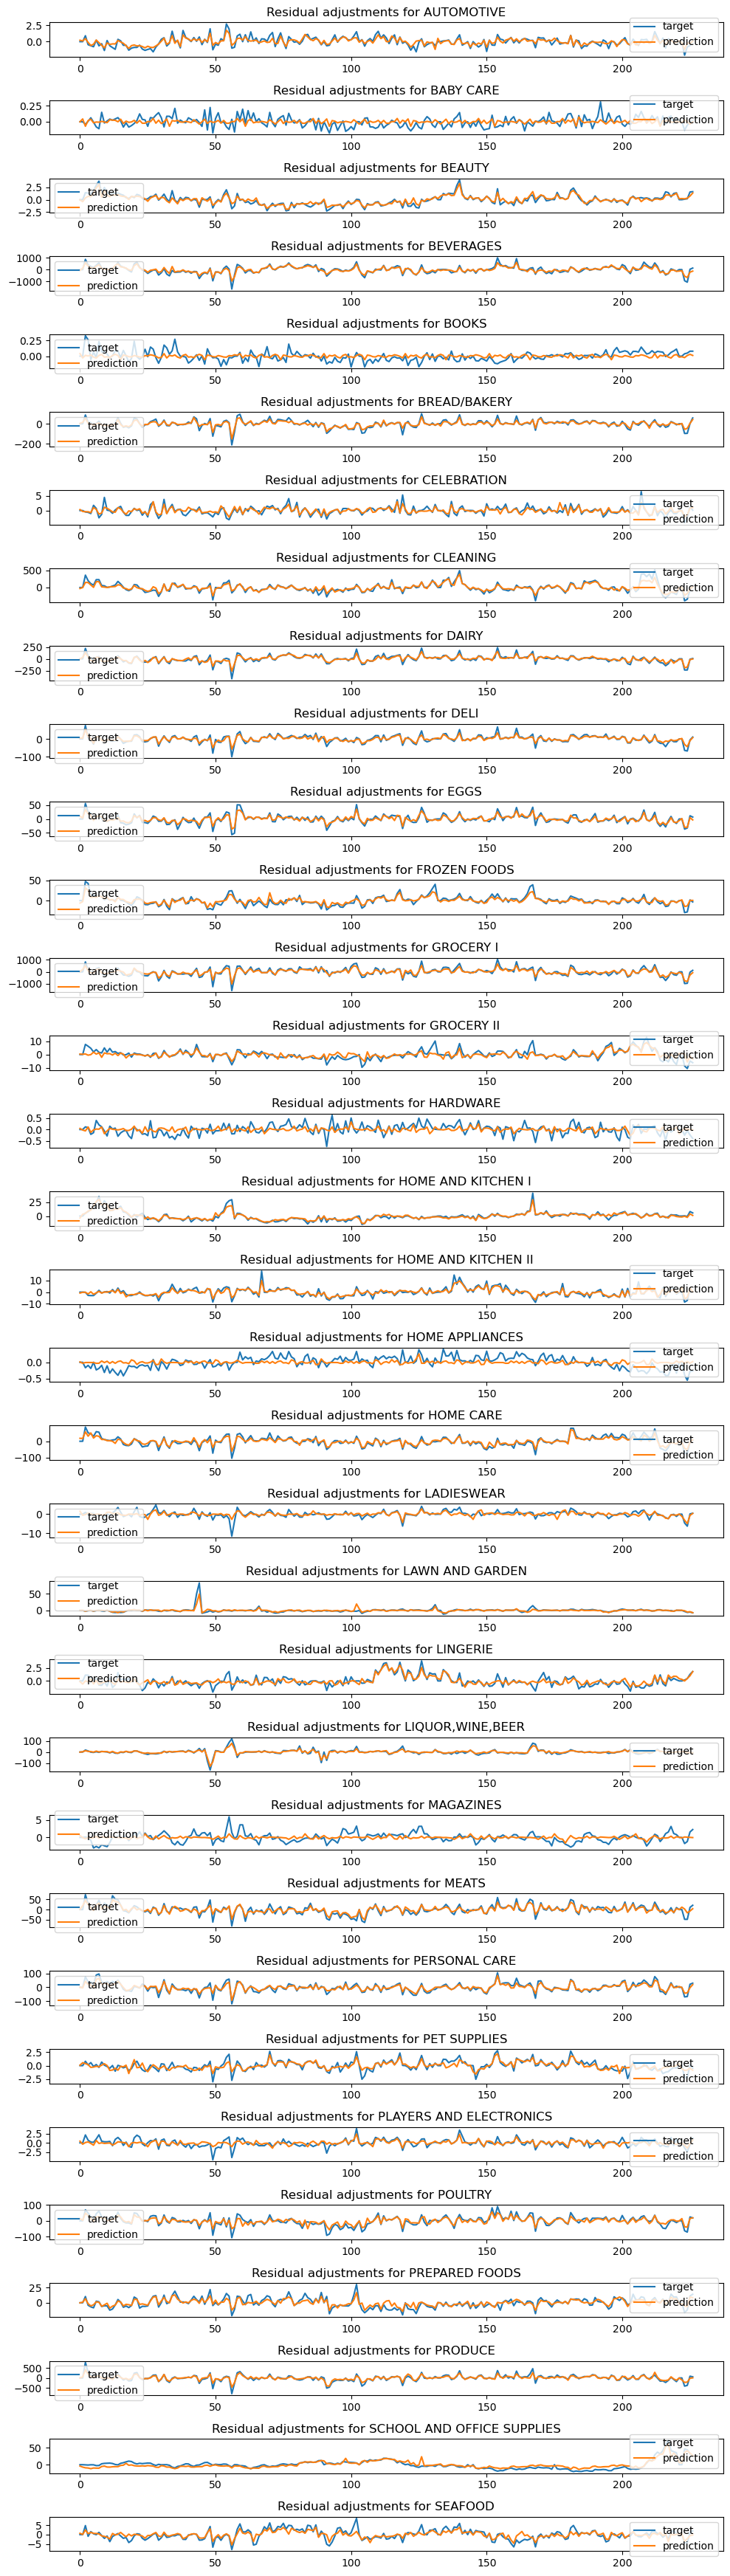

In [220]:
y_pred_resid = model.y_pred_resid.reset_index(level='family')
y_resid = model.y_resid.reset_index(level='family')
n_families = len(y_resid['family'].unique())
fig, ax = plt.subplots(n_families, 1, figsize=(10, 35))
ax = ax.flatten()
for i, (family, group) in enumerate(y_resid.groupby('family', observed=False)):
    ax[i].plot(group['sales'].to_numpy(), label='target')
    ax[i].plot(y_pred_resid[y_pred_resid['family'] == family]['sales'].to_numpy(), label='prediction')
    ax[i].legend()
    ax[i].set_title(f"Residual adjustments for {family}")

plt.tight_layout();

Test how the linear regression (simple) model compares to the hybrid model. The hybrid model seems to fit a bit better on most stores and product families. One store comparison:

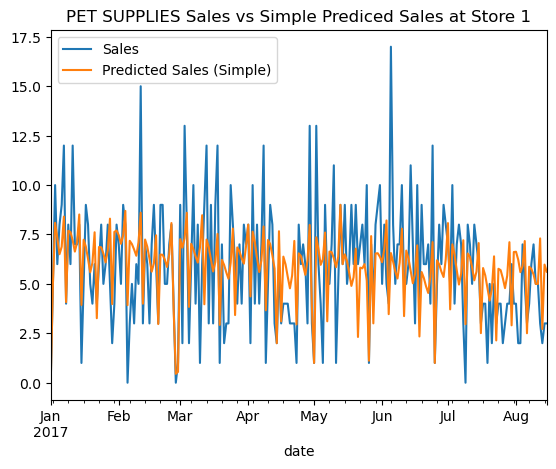

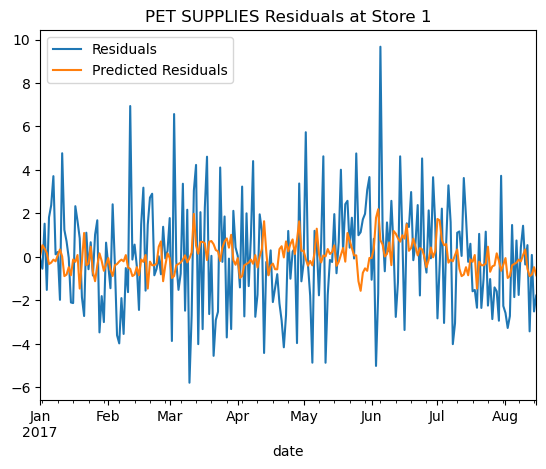

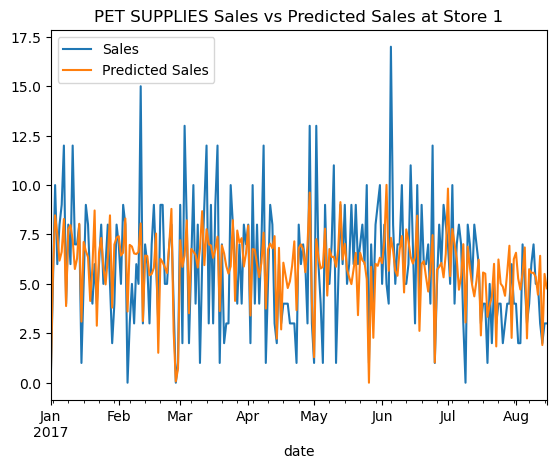

Error 0.547
Error without residual fitting: 0.569


/home/mikael/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [221]:
STORE_NBR = '1'  # 1 - 54
FAMILY = 'PET SUPPLIES'

y_pred_resid = model.y_pred_resid_wide.unstack(["store_nbr", "family"])
y_pred_simple = y_pred - y_pred_resid
y_resid = y - y_pred

def comparison_plot(y1, label1, y2, label2, title):
    # print(y1)
    # print('label1', label1)
    _, ax = plt.subplots()
    y1.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax, label=label1)
    y2.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax, label=label2)
    ax.set_title(title)
    ax.legend()


comparison_plot(y, 'Sales', y_pred_simple, 'Predicted Sales (Simple)', f'{FAMILY} Sales vs Simple Prediced Sales at Store {STORE_NBR}')
comparison_plot(y_resid, 'Residuals', y_pred_resid, 'Predicted Residuals', f'{FAMILY} Residuals at Store {STORE_NBR}')
comparison_plot(y, 'Sales', y_pred, 'Predicted Sales', f'{FAMILY} Sales vs Predicted Sales at Store {STORE_NBR}')
plt.show()


def RMSLE(y_pred, y):
    return np.sqrt(np.mean((np.log(1 + y_pred) - np.log(1 + y)) ** 2))


print('Error', round(RMSLE(y_pred, y), 3))
print('Error without residual fitting:', round(RMSLE(y_pred_simple, y), 3))

Predictions for the test set:

In [222]:
df_test = pd.read_csv(
    data_folder / 'test.csv',
    # usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date']
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test['sales'] = 0
df_test = df_test.set_index(['date', 'store_nbr', 'family']).sort_index()

y_test = df_test.unstack(['store_nbr', 'family'])
X_test = add_holiday_features(dp.out_of_sample(steps=16))
X_test2 = get_family_features(get_family_sales(df_test))

y_pred_submit = model.predict(X_test, X_test2)
y_submit = y_pred_submit.stack(['store_nbr', 'family'], future_stack=True)
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit

id        sales
date       store_nbr family                                          
2017-08-16 1         AUTOMOTIVE                  3000888     4.258861
                     BABY CARE                   3000889     0.040113
                     BEAUTY                      3000890     6.575957
                     BEVERAGES                   3000891  2317.207241
                     BOOKS                       3000892     0.369303
...                                                  ...          ...
2017-08-31 9         POULTRY                     3029395   343.022638
                     PREPARED FOODS              3029396   104.961943
                     PRODUCE                     3029397  1185.745160
                     SCHOOL AND OFFICE SUPPLIES  3029398    66.648353
                     SEAFOOD                     3029399    19.429911

[28512 rows x 2 columns]

In [223]:
y_submit.to_csv('submission.csv', index=False)